In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
import numpy as np
import random
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras import layers
from keras.models import Sequential
 
from matplotlib import pyplot
import matplotlib.pyplot as plt

In [28]:
def load_real_samples():
  (trainX, _), (_, _) = load_data()
  X = trainX.reshape(trainX.shape[0], 28, 28, 1).astype('float32')
  X = (X - 127.5) / 127.5
  return X

(28, 28)


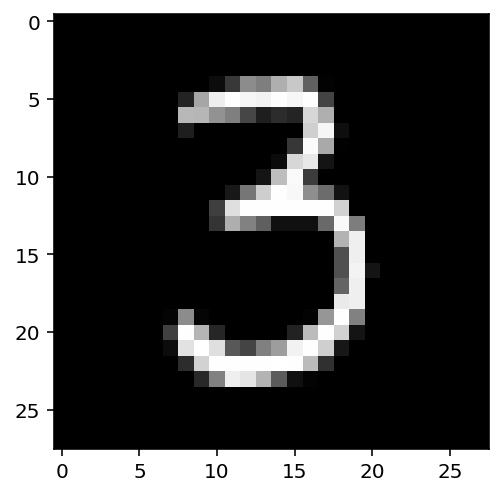

In [29]:
dataset = load_real_samples()
plt.imshow(dataset[50, :, :, 0], cmap='gray')
print(dataset[50, :, :, 0].shape)

In [30]:
# define the standalone generator model
def define_generator(latent_dim=100):
  model = Sequential()
  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(latent_dim,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7, 7, 256)))

  model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
  return model

In [31]:
def generate_latent_points(latent_dim, n_samples):
	x_input = randn(latent_dim * n_samples)
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

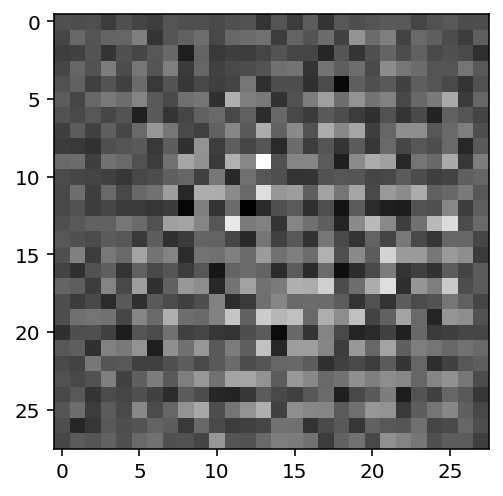

In [32]:
generator = define_generator(100)
noise = generate_latent_points(100,1)
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [33]:
def define_discriminator(in_shape=(28,28,1)):
  model = Sequential()
  model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                    input_shape=[28, 28, 1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  opt = Adam(1e-4)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [34]:
discriminator = define_discriminator()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00329736]], shape=(1, 1), dtype=float32)


In [35]:
def define_gan(g_model, d_model):
  d_model.trainable = False
  model = Sequential()
  model.add(g_model)
  model.add(d_model)
  opt = Adam(1e-4)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

In [36]:
gan = define_gan(generator, discriminator)
noise = generate_latent_points(100,1)
decision = gan(noise)
print (decision)

tf.Tensor([[0.00270311]], shape=(1, 1), dtype=float32)


In [37]:
def generate_real_samples(dataset, n_samples, w):
	# ix = randint(0, dataset.shape[0], n_samples)
	ix = np.random.choice(dataset.shape[0], n_samples, w)
	X = dataset[ix]
	noise = np.random.normal(0,.0001,X.shape)
	X += noise
	y = ones((n_samples, 1))*.9
	return X, y

In [38]:
def generate_fake_samples(g_model, latent_dim, n_samples):
	x_input = generate_latent_points(latent_dim, n_samples)
	X = g_model.predict(x_input)
	noise = np.random.normal(0,.0001,X.shape)
	X += noise
	y = ones((n_samples, 1))*.1
	return X, y

In [39]:
# def save_plot(examples, epoch, modelnumber, n=10, adagan =''):
# 	examples = (examples + 1) / 2.0
# 	for i in range(n * n):
# 		pyplot.subplot(n, n, 1 + i)
# 		pyplot.axis('off')
# 		pyplot.imshow(examples[i, :, :, 0], cmap='gray')
	
# 	filename = '/content/drive/My Drive/Colab Notebooks/DL/Project/generated_plot{0}_m{1:03}_e{2:03}.png'.format(adagan, modelnumber , (epoch+1))
# 	print(filename)
# 	pyplot.savefig(filename)
# 	pyplot.close()
def save_plot(examples, epoch, modelnumber, n=10, adagan =''):
	examples = (examples + 1) / 2.0
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, 0], cmap='gray')
	
	filename = '/content/drive/My Drive/Colab Notebooks/DL/Project/generated_plot{0}_m{1:03}_e{2:03}.png'.format(adagan, modelnumber , (epoch+1))
	print(filename)
	plt.savefig(filename)

In [40]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, modelnumber, n_samples=150):
	# X_real, y_real = generate_real_samples(dataset, n_samples)
	# _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	save_plot(x_fake, epoch, modelnumber)
	# filename = 'generator_model_%03d.h5' % (epoch+1)
	# print(filename)
	# g_model.save(filename)

In [41]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, n_batch ,w, modelnumber):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	# bat_per_epo = 20
	half_batch = n_batch

	g_loss_list = []
	d_loss_list = []
	for i in range(n_epochs):
		sd_loss = 0
		sg_loss = 0
		for j in range(bat_per_epo):
			X_real, y_real = generate_real_samples(dataset, half_batch, w)
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			X_gan = generate_latent_points(latent_dim, n_batch)
			y_gan = ones((n_batch, 1))
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			sd_loss += d_loss1+d_loss2
			sg_loss += g_loss
			if (j+1) % 10 == 0:
				print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
					(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
		d_loss_list.append(sd_loss)
		g_loss_list.append(sg_loss)
		# if (i+1) % 10 == 0:
		summarize_performance(i, g_model, d_model, dataset, latent_dim, modelnumber)
	
	plt.figure(figsize = (12, 12))
	%config InlineBackend.figure_format ='retina'
	plt.plot(d_loss_list, color = 'm', linewidth = 3, label = 'Discriminator loss')
	plt.plot(g_loss_list, color = 'orangered', linewidth = 3, label = 'Generator loss')
	plt.legend(loc = 'best')
	plt.grid(color = 'black', linestyle = '--', linewidth = 0.4)

	sequence_length = 20
	shift_size = 1

	plt.xlabel('epochs', fontsize = 14)
	plt.ylabel('Loss', fontsize = 14)   
	plt.xticks(fontname = "Times New Roman", fontsize = 14)      
	plt.yticks(fontname = "Times New Roman", fontsize = 14)

	filename = '/content/drive/My Drive/Colab Notebooks/DL/Project/loss_plot_m%03d.png' % modelnumber
	plt.savefig(filename)



In [42]:
def dcgan(w, modelnumber, latent_dim, n_epochs, n_batch, dataset):

  d_model = define_discriminator()
  g_model = define_generator(latent_dim)
  gan_model = define_gan(g_model, d_model)
  train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, n_batch , w, modelnumber)
  return g_model, d_model


# latent_dim = 8
# n_epochs = 5
# n_batch = 128
# dataset = load_real_samples()
# w = (np.ones(dataset.shape[0])/dataset.shape[0]).tolist()
# g_model, d_model = dcgan(w, 1, latent_dim, n_epochs, n_batch, dataset)

In [43]:
def generate_adagan_fake_samples(g_models, alphas, latent_dim, n_samples):
  ix = np.random.choice(len(g_models), n_samples, alphas).tolist()
  first = True
  for i in range(len(g_models)):
    n_samples_in_g = ix.count(i)
    x_fake, y_fake = generate_fake_samples(g_models[i], latent_dim, n_samples_in_g)
    if first:
      first = False
      x = x_fake
      y = y_fake
    else:
      x = np.append(x,x_fake,0)
      y = np.append(y,y_fake,0)
  return x,y

In [44]:
# g_models = [g_model, g_model]
# alphas = [.5,.5]
# a = generate_adagan_fake_samples(g_models, alphas, 8, 100)


In [45]:
def train_adagan_discriminator(g_models, alphas, d_model, dataset, latent_dim, n_epochs, n_batch, modelnumber):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  # bat_per_epo = 10
  half_batch = n_batch
  w = (np.ones(dataset.shape[0])/dataset.shape[0]).tolist()
  d_loss_list = []
  for i in range(n_epochs):
    sd_loss = 0
    for j in range(bat_per_epo):
      X_real, y_real = generate_real_samples(dataset, half_batch, w)
      d_loss1, _ = d_model.train_on_batch(X_real, y_real)

      X_fake, y_fake = generate_adagan_fake_samples(g_models, alphas, latent_dim, half_batch)
      d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
      sd_loss += d_loss1+d_loss2

      if (j+1) % 10 == 0:
        print('>%d, %d/%d, d1=%.3f, d2=%.3f' %
          (i+1, j+1, bat_per_epo, d_loss1, d_loss2))
    d_loss_list.append(sd_loss)
	
  plt.figure(figsize = (12, 12))
  %config InlineBackend.figure_format ='retina'
  plt.plot(d_loss_list, color = 'm', linewidth = 3, label = 'Discriminator loss')
  plt.legend(loc = 'best')
  plt.grid(color = 'black', linestyle = '--', linewidth = 0.4)

  sequence_length = 20
  shift_size = 1

  plt.xlabel('epochs', fontsize = 14)
  plt.ylabel('Loss', fontsize = 14)   
  plt.xticks(fontname = "Times New Roman", fontsize = 14)      
  plt.yticks(fontname = "Times New Roman", fontsize = 14)

  filename = '/content/drive/My Drive/Colab Notebooks/DL/Project/loss_adagan_discriminator_plot_m%03d.png' % modelnumber
  plt.savefig(filename)

In [46]:
def adagan_discriminator(g_models, alphas, dataset, latent_dim, n_epochs, n_batch, modelnumber):
  discriminator = define_discriminator()
  train_adagan_discriminator(g_models, alphas, discriminator, dataset, latent_dim, n_epochs, n_batch, modelnumber)
  return discriminator


In [47]:
def sigmoid(x):
    s = 1/(1+np.exp(-x)) 
    return s

In [48]:
def _compute_data_weights_theory_star(beta, ratios, num):
  ratios_sorted = np.sort(ratios)
  cumsum_ratios = np.cumsum(ratios_sorted)
  is_found = False
  for i in range(num):
      _lambda = beta * num * (1. + (1.-beta) / beta \
              / num * cumsum_ratios[i]) / (i + 1.)
      if i == num - 1:
          if _lambda >= (1. - beta) * ratios_sorted[-1]:
              is_found = True
              break
      else:
          if _lambda <= (1 - beta) * ratios_sorted[i + 1] \
                  and _lambda >= (1 - beta) * ratios_sorted[i]:
              is_found = True
              break
  data_weights = np.zeros(num)
  if is_found:
      _lambdamask = ratios <= (_lambda / (1.-beta))
      data_weights[_lambdamask] = (_lambda -
                                    (1-beta)*ratios[_lambdamask]) / num / beta
      data_weights = data_weights / np.sum(data_weights)
      return data_weights
  else:
      data_weights = np.ones(num) / (num + 0.)
      return data_weights

In [49]:
latent_dim = 8
n_epochs = 40
n_discriminator_epochs = 5
n_batch = 128
dataset = load_real_samples()

g_models = []
alphas = []
T = 10
w = (np.ones(dataset.shape[0])/dataset.shape[0]).tolist()
g_model, d_model = dcgan(w, 1, latent_dim, n_epochs, n_batch, dataset)
g_models.append(g_model)
alphas.append(1)
metric = []
for i in range(2, T):
  beta = 1/i
  discriminator = adagan_discriminator(g_models, alphas, dataset, latent_dim, n_discriminator_epochs, n_batch, 2)
  prob_real_data = discriminator.predict(dataset, batch_size=256)
  prob_real_data = sigmoid(prob_real_data)

  metric.append(np.sum(prob_real_data))


  density_ratios = ((1. - prob_real_data) / (prob_real_data + 1e-8)).flatten()

  w = list(_compute_data_weights_theory_star(beta, density_ratios, dataset.shape[0]))
  

  g_model, d_model = dcgan(w, i, latent_dim, n_epochs, n_batch, dataset)
  g_models.append(g_model)

  tmp = np.array(alphas)
  tmp = tmp * (1 - beta)
  alphas.append(beta)

  X_fake, _ = generate_adagan_fake_samples(g_models, alphas, latent_dim, 150)
  save_plot(X_fake, 0, i, n=10, adagan ='adagan')



plt.figure(figsize = (12, 12))
%config InlineBackend.figure_format ='retina'
plt.plot(metric, color = 'm', linewidth = 3)
plt.legend(loc = 'best')
plt.grid(color = 'black', linestyle = '--', linewidth = 0.4)

filename = '/content/drive/My Drive/Colab Notebooks/DL/Project/metric.png'
plt.savefig(filename)



Output hidden; open in https://colab.research.google.com to view.